<a href="https://colab.research.google.com/github/AlexeyUdod/aml/blob/master/dll_4_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Основное задание
Возьмите датасет https://www.kaggle.com/ajayrana/hymenoptera-data/kernels

1.Обучите на нем модели ResNet 18 и VGG 16 с нуля (5-10 эпох)

2.Обучите на нем модели ResNet 18 и VGG 16 с использованием FineTuning (5-10 эпох)

3.Добавьте аугментацию данных к пункту 2

Сравните качество всех 3 полученных подходов


In [5]:
import torch as tr
import torchvision as trv
import os
from torch.nn import *
from functools import reduce
from operator import mul
import time
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


In [6]:
import platform
if platform.system() == 'Linux':
    path = '/content/drive/My Drive/Colab Notebooks/dll/hymenoptera_data/'
    from google.colab import drive
    drive.mount('/content/drive')
else:
    path = ""#"d:\drive\Colab Notebooks\dll\hymenoptera_data\"""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
transform = trv.transforms.Compose([trv.transforms.ToTensor(), 
                                    trv.transforms.Resize((224,224)), 
                                    trv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

augs = trv.transforms.Compose([trv.transforms.RandomResizedCrop((224, 224)),
                               trv.transforms.RandomHorizontalFlip(),
                               trv.transforms.ToTensor(),
                               trv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
batch_size = 50
batch_size_test = 50 
train = tr.utils.data.DataLoader(trv.datasets.ImageFolder(os.path.join(path, 'train'), transform=transform), batch_size, shuffle=True)
train_augs = tr.utils.data.DataLoader(trv.datasets.ImageFolder(os.path.join(path, 'train'), transform=augs), batch_size, shuffle=True)
test = tr.utils.data.DataLoader(trv.datasets.ImageFolder(os.path.join(path, 'val'), transform=transform), batch_size = batch_size_test)

In [32]:
def train_model(model, train, test, n_epoch):
  tr.cuda.empty_cache()
  output_size = 2
  device = tr.device("cuda:0" if tr.cuda.is_available() else "cpu")
  print(f'work at {(tr.cuda.get_device_name() if tr.cuda.is_available() else "cpu")}')

  model = model.to(device)

  loss = CrossEntropyLoss().to(device)
  optimizer = tr.optim.Adam(model.parameters(), lr = 0.0001)

  start0 = time.time()
  l_speed_history = [0]
  score_history = [0]
  for ep in range(n_epoch):
      start = time.time()
      model.train()
      for X, y in (train):
          X, y = X.to(device), y.to(device)
          optimizer.zero_grad()
          y_pred = model(X).to(device)
          l = loss(y_pred, y).to(device)
          l.backward()
          optimizer.step()
          train_score = tr.sum(tr.argmax(y_pred, axis=1) == y).item() / y.shape[0] 
          
      model.eval()
      for X, y in (test):
          X = X.to(device)
          y = y.to(device)
          y_pred = model(X).to(device)
          test_score = tr.sum(tr.argmax(y_pred, axis=1) == y).item() / y.shape[0] 
      score_history.append(test_score)
      dtime = time.time() - start
      total_dtime = time.time() - start0
      l_speed = (score_history[-1] - score_history[-2]) / dtime
      l_speed_history.append(l_speed)
      p_speed = test_score / total_dtime
      print(f'epoch {ep}, loss {round(l.item(), 4)}, train_score {train_score}, test_score {test_score}, epoch time {round(dtime, 2)} sec,  acc% / sec {round(l_speed*100, 7)}, total_acc% / sec {round(p_speed*100, 6)}')  

  return l_speed_history, score_history

In [33]:
r18 = trv.models.resnet18(pretrained=False)
r18.fc = Linear(in_features=512, out_features=2, bias=True)

vgg = trv.models.vgg16(pretrained=False)
vgg.classifier[-1] = Linear(in_features=4096, out_features=2, bias=True)

r18_not_pretrained = train_model(r18, train, test, 10)
vgg_not_pretrained = train_model(vgg, train, test, 10)

work at Tesla P100-PCIE-16GB
epoch 0, loss 0.6025, train_score 0.6136363636363636, test_score 0.3333333333333333, epoch time 4.49 sec,  acc% / sec 7.4314451, total_acc% / sec 7.431438
epoch 1, loss 0.5357, train_score 0.7272727272727273, test_score 1.0, epoch time 4.43 sec,  acc% / sec 15.0376415, total_acc% / sec 11.212081
epoch 2, loss 0.2488, train_score 0.9318181818181818, test_score 1.0, epoch time 4.49 sec,  acc% / sec 0.0, total_acc% / sec 7.455741
epoch 3, loss 0.1724, train_score 0.9318181818181818, test_score 1.0, epoch time 4.5 sec,  acc% / sec 0.0, total_acc% / sec 5.583184
epoch 4, loss 0.0325, train_score 1.0, test_score 1.0, epoch time 4.48 sec,  acc% / sec 0.0, total_acc% / sec 4.466662
epoch 5, loss 0.0186, train_score 1.0, test_score 1.0, epoch time 4.47 sec,  acc% / sec 0.0, total_acc% / sec 3.723121
epoch 6, loss 0.0073, train_score 1.0, test_score 1.0, epoch time 4.43 sec,  acc% / sec 0.0, total_acc% / sec 3.195817
epoch 7, loss 0.0026, train_score 1.0, test_score 

In [43]:
r18 = trv.models.resnet18(pretrained=True)
r18.fc = Linear(in_features=512, out_features=2, bias=True)

vgg = trv.models.vgg16(pretrained=True)
vgg.classifier[-1] = Linear(in_features=4096, out_features=2, bias=True)

r18_pretrained = train_model(r18, train, test, 10)
vgg_pretrained = train_model(vgg, train, test, 10)

work at Tesla P100-PCIE-16GB
epoch 0, loss 0.4248, train_score 0.7727272727272727, test_score 1.0, epoch time 4.54 sec,  acc% / sec 22.0279068, total_acc% / sec 22.027841
epoch 1, loss 0.0503, train_score 1.0, test_score 1.0, epoch time 4.46 sec,  acc% / sec 0.0, total_acc% / sec 11.112048
epoch 2, loss 0.0419, train_score 1.0, test_score 1.0, epoch time 4.49 sec,  acc% / sec 0.0, total_acc% / sec 7.415453
epoch 3, loss 0.0051, train_score 1.0, test_score 1.0, epoch time 4.48 sec,  acc% / sec 0.0, total_acc% / sec 5.565291
epoch 4, loss 0.0018, train_score 1.0, test_score 1.0, epoch time 4.49 sec,  acc% / sec 0.0, total_acc% / sec 4.45322
epoch 5, loss 0.0021, train_score 1.0, test_score 1.0, epoch time 4.49 sec,  acc% / sec 0.0, total_acc% / sec 3.711
epoch 6, loss 0.0015, train_score 1.0, test_score 1.0, epoch time 4.49 sec,  acc% / sec 0.0, total_acc% / sec 3.180557
epoch 7, loss 0.0013, train_score 1.0, test_score 1.0, epoch time 4.51 sec,  acc% / sec 0.0, total_acc% / sec 2.781262

In [44]:
r18 = trv.models.resnet18(pretrained=True)
r18.fc = Linear(in_features=512, out_features=2, bias=True)

vgg = trv.models.vgg16(pretrained=True)
vgg.classifier[-1] = Linear(in_features=4096, out_features=2, bias=True)

r18_pretrained_augs = train_model(r18, train_augs, test, 10)
vgg_pretrained_augs = train_model(vgg, train_augs, test, 10)

work at Tesla P100-PCIE-16GB
epoch 0, loss 0.3204, train_score 0.9090909090909091, test_score 1.0, epoch time 4.25 sec,  acc% / sec 23.5218679, total_acc% / sec 23.521853
epoch 1, loss 0.1861, train_score 0.9545454545454546, test_score 1.0, epoch time 4.26 sec,  acc% / sec 0.0, total_acc% / sec 11.750841
epoch 2, loss 0.0603, train_score 1.0, test_score 1.0, epoch time 4.21 sec,  acc% / sec 0.0, total_acc% / sec 7.860755
epoch 3, loss 0.081, train_score 0.9772727272727273, test_score 1.0, epoch time 4.26 sec,  acc% / sec 0.0, total_acc% / sec 5.888212
epoch 4, loss 0.0722, train_score 0.9772727272727273, test_score 1.0, epoch time 4.22 sec,  acc% / sec 0.0, total_acc% / sec 4.716353
epoch 5, loss 0.0424, train_score 1.0, test_score 1.0, epoch time 4.23 sec,  acc% / sec 0.0, total_acc% / sec 3.93137
epoch 6, loss 0.0645, train_score 0.9772727272727273, test_score 1.0, epoch time 4.27 sec,  acc% / sec 0.0, total_acc% / sec 3.36627
epoch 7, loss 0.0806, train_score 0.9772727272727273, tes

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

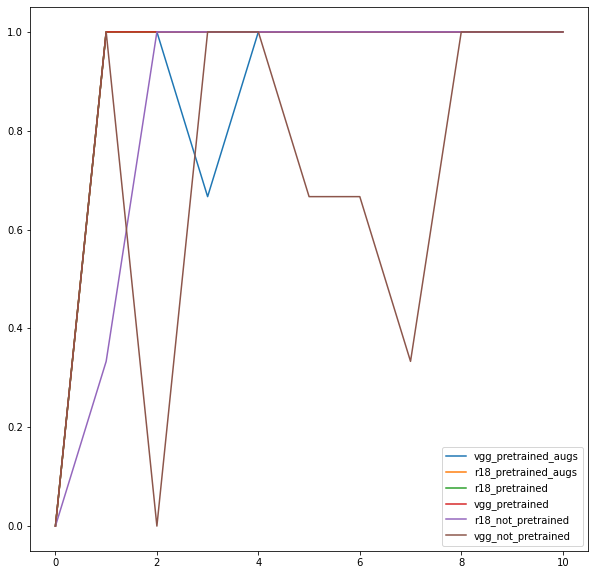

In [60]:
sns.lineplot(range(11), vgg_pretrained_augs[1], label='vgg_pretrained_augs')
sns.lineplot(range(11), r18_pretrained_augs[1], label='r18_pretrained_augs')
sns.lineplot(range(11), r18_pretrained[1], label='r18_pretrained')
sns.lineplot(range(11), vgg_pretrained[1], label='vgg_pretrained')
sns.lineplot(range(11), r18_not_pretrained[1], label='r18_not_pretrained')
sns.lineplot(range(11), vgg__not_pretrained[1], label='vgg_not_pretrained')
plt.gcf().set_size_inches(10, 10)

Предобученные модели с аугментацией обучаются быстрее и работают лучше.

